<a href="https://colab.research.google.com/github/Wanita-8943/run/blob/main/B0_3_(8e-5)_Gender3_Train_Freeze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import shutil

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

In [4]:
batch_size = 16
width = 150
height = 150
epochs = 250
NUM_TRAIN = 2850
NUM_TEST = 950
dropout_rate = 0.2
input_shape = (height, width, 3)

In [5]:
#ดึงข้อมูลใน Github มาใช้
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
 !git clone https://github.com/Wanita-8943/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/

/content
Cloning into 'efficientnet_keras_transfer_learning'...
remote: Enumerating objects: 1070, done.
remote: Counting objects: 100% (233/233), done.
remote: Compressing objects: 100% (154/154), done.
remote: Total 1070 (delta 115), reused 161 (delta 79), pack-reused 837
Receiving objects: 100% (1070/1070), 13.93 MiB | 18.92 MiB/s, done.
Resolving deltas: 100% (612/612), done.
/content/efficientnet_keras_transfer_learning


In [6]:
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.
from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input

#load model

In [7]:
import sys
sys.path.append('/content/drive/MyDrive/cut_panoramic/Model/Clssification Gender/ครั้งที่ 6/GG2_2e-4_250.h5')

from efficientnet.layers import Swish, DropConnect
from efficientnet.model import ConvKernalInitializer
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({
    'ConvKernalInitializer': ConvKernalInitializer,
    'Swish': Swish,
    'DropConnect':DropConnect
})

In [8]:
#load model 
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/cut_panoramic/Model/Clssification Gender/ครั้งที่ 6/GG2_2e-4_250.h5')
height = width = model.input_shape[1]

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 5, 5, 1280)       4049564   
 )                                                               
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1280)              0         
                                                                 
 dropout_out (Dropout)       (None, 1280)              0         
                                                                 
 fc_out (Dense)              (None, 2)                 2562      
                                                                 
Total params: 4,052,126
Trainable params: 2,562
Non-trainable params: 4,049,564
_________________________________________________________________


In [9]:
df = pd.read_csv (r'/content/drive/MyDrive/cut_panoramic/Data/New_Data_Gender.csv')
df

,Fig_Age,Fig_Person_Sex,Age(year),Class,Class_Re,Filename,Path_filename,Sex,Floder
0,1,1,7,Y07F,0,V1.jpg,/content/drive/My Drive/TVT_Gender/train/Femal...,Female,Both
1,2,1,7,Y07F,0,Flip_V1.jpg,/content/drive/My Drive/TVT_Gender/train/Femal...,Female,Both
2,3,2,7,Y07F,0,V2.jpg,/content/drive/My Drive/TVT_Gender/train/Femal...,Female,Both
3,4,2,7,Y07F,0,Flip_V2.jpg,/content/drive/My Drive/TVT_Gender/train/Femal...,Female,Both
4,5,3,7,Y07F,0,V3.jpg,/content/drive/My Drive/TVT_Gender/train/Femal...,Female,Both
...,...,...,...,...,...,...,...,...,...
4745,121,77,25,Y25M,1,Flip_J463.jpg,/content/drive/My Drive/TVT_Gender/test/Male/F...,Male,Both
4746,122,78,25,Y25M,1,J464.jpg,/content/drive/My Drive/TVT_Gender/test/Male/J...,Male,Both
4747,123,78,25,Y25M,1,Flip_J464.jpg,/content/drive/My Drive/TVT_Gender/test/Male/F...,Male,Both
4748,124,79,25,Y25M,1,J465.jpg,/content/drive/My Drive/TVT_Gender/test/Male/J...,Male,Both


In [10]:
train = df[df['Fig_Age'].between(1,75)]
val = df[df['Fig_Age'].between(76,100)]

In [11]:
DATA_PATH = "/content/drive/My Drive/TVT_Gender"
os.chdir(DATA_PATH)
train_dir = os.path.join(DATA_PATH, 'train')
print(train_dir)
validation_dir = os.path.join(DATA_PATH, 'validation')
print(validation_dir)

/content/drive/My Drive/TVT_Gender/train
/content/drive/My Drive/TVT_Gender/validation


In [12]:
# Train ด้วย ImageDataGenerator ของ Keras ซึ่งจะเพิ่มข้อมูลเสริมระหว่างการฝึกเพื่อลดโอกาสเกิด overfitting
#overfitting เกิดจากข้อมูลที่ซับซ้อนกันเกินไป
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255, #โมเดลส่วนใหญ่ต้องใช้ RGB ในช่วง 0–1
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe = train,
        directory = train_dir,
        x_col = 'Path_filename',
        y_col = 'Sex',
        class_mode = 'categorical',
        target_size=(height, width),
        batch_size=batch_size)

validation_generator = test_datagen.flow_from_dataframe(
        dataframe = val,
        directory = validation_dir,
        x_col = 'Path_filename',
        y_col = 'Sex',
        class_mode = 'categorical',
        target_size=(height, width),
        batch_size=batch_size)

Found 2850 validated image filenames belonging to 2 classes.
Found 950 validated image filenames belonging to 2 classes.


In [13]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=8e-5),
              metrics=['acc'])
history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

<ipython-input-13-5b290c04e531>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/250
178/178 [==============================] - 231s 1s/step - loss: 0.6093 - acc: 0.6733 - val_loss: 0.6047 - val_acc: 0.6790
Epoch 2/250
178/178 [==============================] - 24s 134ms/step - loss: 0.6125 - acc: 0.6747 - val_loss: 0.5577 - val_acc: 0.7182
Epoch 3/250
178/178 [==============================] - 25s 137ms/step - loss: 0.6011 - acc: 0.6789 - val_loss: 0.5405 - val_acc: 0.7172
Epoch 4/250
178/178 [==============================] - 24s 133ms/step - loss: 0.6107 - acc: 0.6743 - val_loss: 0.5703 - val_acc: 0.7108
Epoch 5/250
178/178 [==============================] - 24s 133ms/step - loss: 0.6048 - acc: 0.6733 - val_loss: 0.5632 - val_acc: 0.7140
Epoch 6/250
178/178 [==============================] - 24s 133ms/step - loss: 0.6123 - acc: 0.6662 - val_loss: 0.5325 - val_acc: 0.7256
Epoch 7/250
178/178 [==============================] - 24s 133ms/step - loss: 0.6051 - acc: 0.6606 - val_loss: 0.5514 - val_acc: 0.7246
Epoch 8/250
178/178 [=============================

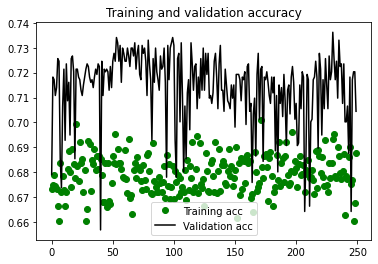

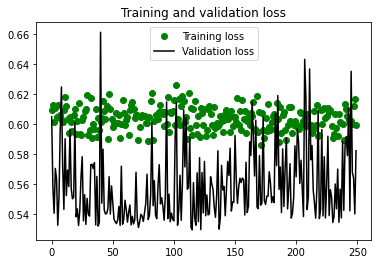

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'go', label='Training acc')
plt.plot(epochs_x, val_acc, 'k', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'go', label='Training loss')
plt.plot(epochs_x, val_loss, 'k', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#Download the model

In [15]:
os.makedirs('/content/drive/My Drive/cut_panoramic/Model', exist_ok=True)
model.save('/content/drive/MyDrive/cut_panoramic/Model/Clssification Gender/ครั้งที่ 6/(8e-5)_B0_G3_Freeze.h5')

In [ ]:
# from google.colab import files
# files.download('/content/drive/My Drive/cut_panoramic/Model/2_รอบที่2_Gender_250.h5')